In [1]:
import gabscraping as scr
import info_score 
import matplotlib.pyplot as plt
import numpy as np
import json
from time import sleep
from tqdm import tqdm
from textblob import TextBlob
from nltk.stem.snowball import SnowballStemmer

retrieve_forbes_new = True
create_simil_matr_new = True


In [41]:
# gets the classification according to Forbes
if(not retrieve_forbes_new):
    try:
        with open('forbes_startups.json', 'r') as f:
            data = f.read()
            forb_startups = json.loads(data)
        print('Loaded data from forbes_startups.json')
    except:
        print('No forbes_startups.json found; retrieving data from forbes.com...')
else:
    fails = []
    forbessoup = scr.get_soup('https://www.forbes.com/sites/ninaangelovska/2018/11/26/meet-the-100-most-innovative-startups-of-germany-in-2018/')
    forb_classification = {}
    list_of_startups = forbessoup.ol.find_all('li')[::2]
    pbar = tqdm(list_of_startups)
    for li in pbar:
        category = li.text.replace(li.a.text, '').replace('(', '').replace(')', '').strip()
        name = li.a.text.replace(u'\xa0', u' ')
        pbar.set_description(name)
        thisurl = li.a['href']
        category = category.strip().lower()
        if category not in forb_classification:
            forb_classification[category] = []
        forb_classification[category].append({'name': name, 'url': thisurl})
    #forb_classification;
    forb_startups = []
    pbar = tqdm(forb_classification.keys())
    
    stemmer = SnowballStemmer("english")
    for k in pbar:
        for st in forb_classification[k]:
            pbar.set_description(' '.join([st['name'], st['url'], k]))
            try: 
                this_descr = TextBlob(scr.get_body_text(st['url']))
                if this_descr.detect_language() != 'en':
                    this_descr = this_descr.translate(to='en')     
                this_descr = [stemmer.stem(w) for w in info_score.words_from_text(str(this_descr))]
                wds = scr.Words()
                wds.add_text(' '.join(this_descr))
                how_many_words = 20
                this_descr_words = [w[0] for w in wds.sorted_words()[:how_many_words]]
                if(len(this_descr_words) >= how_many_words-1):
                    forb_startups.append({'name': st['name'], 'url': st['url'], 'category': k,
                                 'description': ' '.join(this_descr_words)})
                                      #' '.join(info_score.words_from_text(
                                     #this_descr[:min(len(this_descr), 10000)]))})
            except:
                fails.append(st['name'])
                #this_descr = ''
    print(str(len(fails))+'/'+str(len(list_of_startups))+' fails: '+', '.join(fails))
    with open('forbes_startups.json', 'w') as f:
        data = json.dumps(forb_startups)
        f.write(data)
        
        
descr_collection = [f['description'] for f in forb_startups]
catalogue = {f['name']: f for f in forb_startups}

SIRPLUS http://sirplus.de/ food: 100%|██████████| 28/28 [00:49<00:00,  1.78s/it]                                          

1/50 fails: Vivy


In [43]:
if create_simil_matr_new:
    similarity_matrix = []

    pbar = tqdm(forb_startups)


    for f1 in pbar:
        #print(f1['name'], forb_startups.index(f1)+1, '/', len(forb_startups))
        similarity_matrix.append([])
        for f2 in forb_startups:
            pbar.set_description(f1['name']+' : '+f2['name']+'('+str(
                forb_startups.index(f2)+1)+'/'+str(len(forb_startups))+')')
            if (info_score.words_from_text(f1['description']) == '' or
                info_score.words_from_text(f2['description']) == '' or 
                forb_startups.index(f2)<=forb_startups.index(f1)):
                sim_score = float('nan')
            else:
                sim_score = info_score.similarity_score(f1['description'].strip(), f2['description'], 
                                                        descr_collection)
                try:
                    float(sim_score)
                except:
                    print(':( '+f1['name']+' : '+f2['name'])
            similarity_matrix[-1].append(sim_score)
                
            #print(similarity_matrix[-1][-1])
        #similarity_matrix.append([info_score.similarity_score(f1['description'], f2['description'], descr_collection) for f2 in forb_startups])
    np.savetxt('simil_matrix', similarity_matrix)
else:
    np.save('simil_matrix', x)
    similarity_matrix = np.load('simil_matrix'+ '.npy')


SIRPLUS : SIRPLUS(48/48): 100%|██████████| 48/48 [00:08<00:00,  5.35it/s]                        


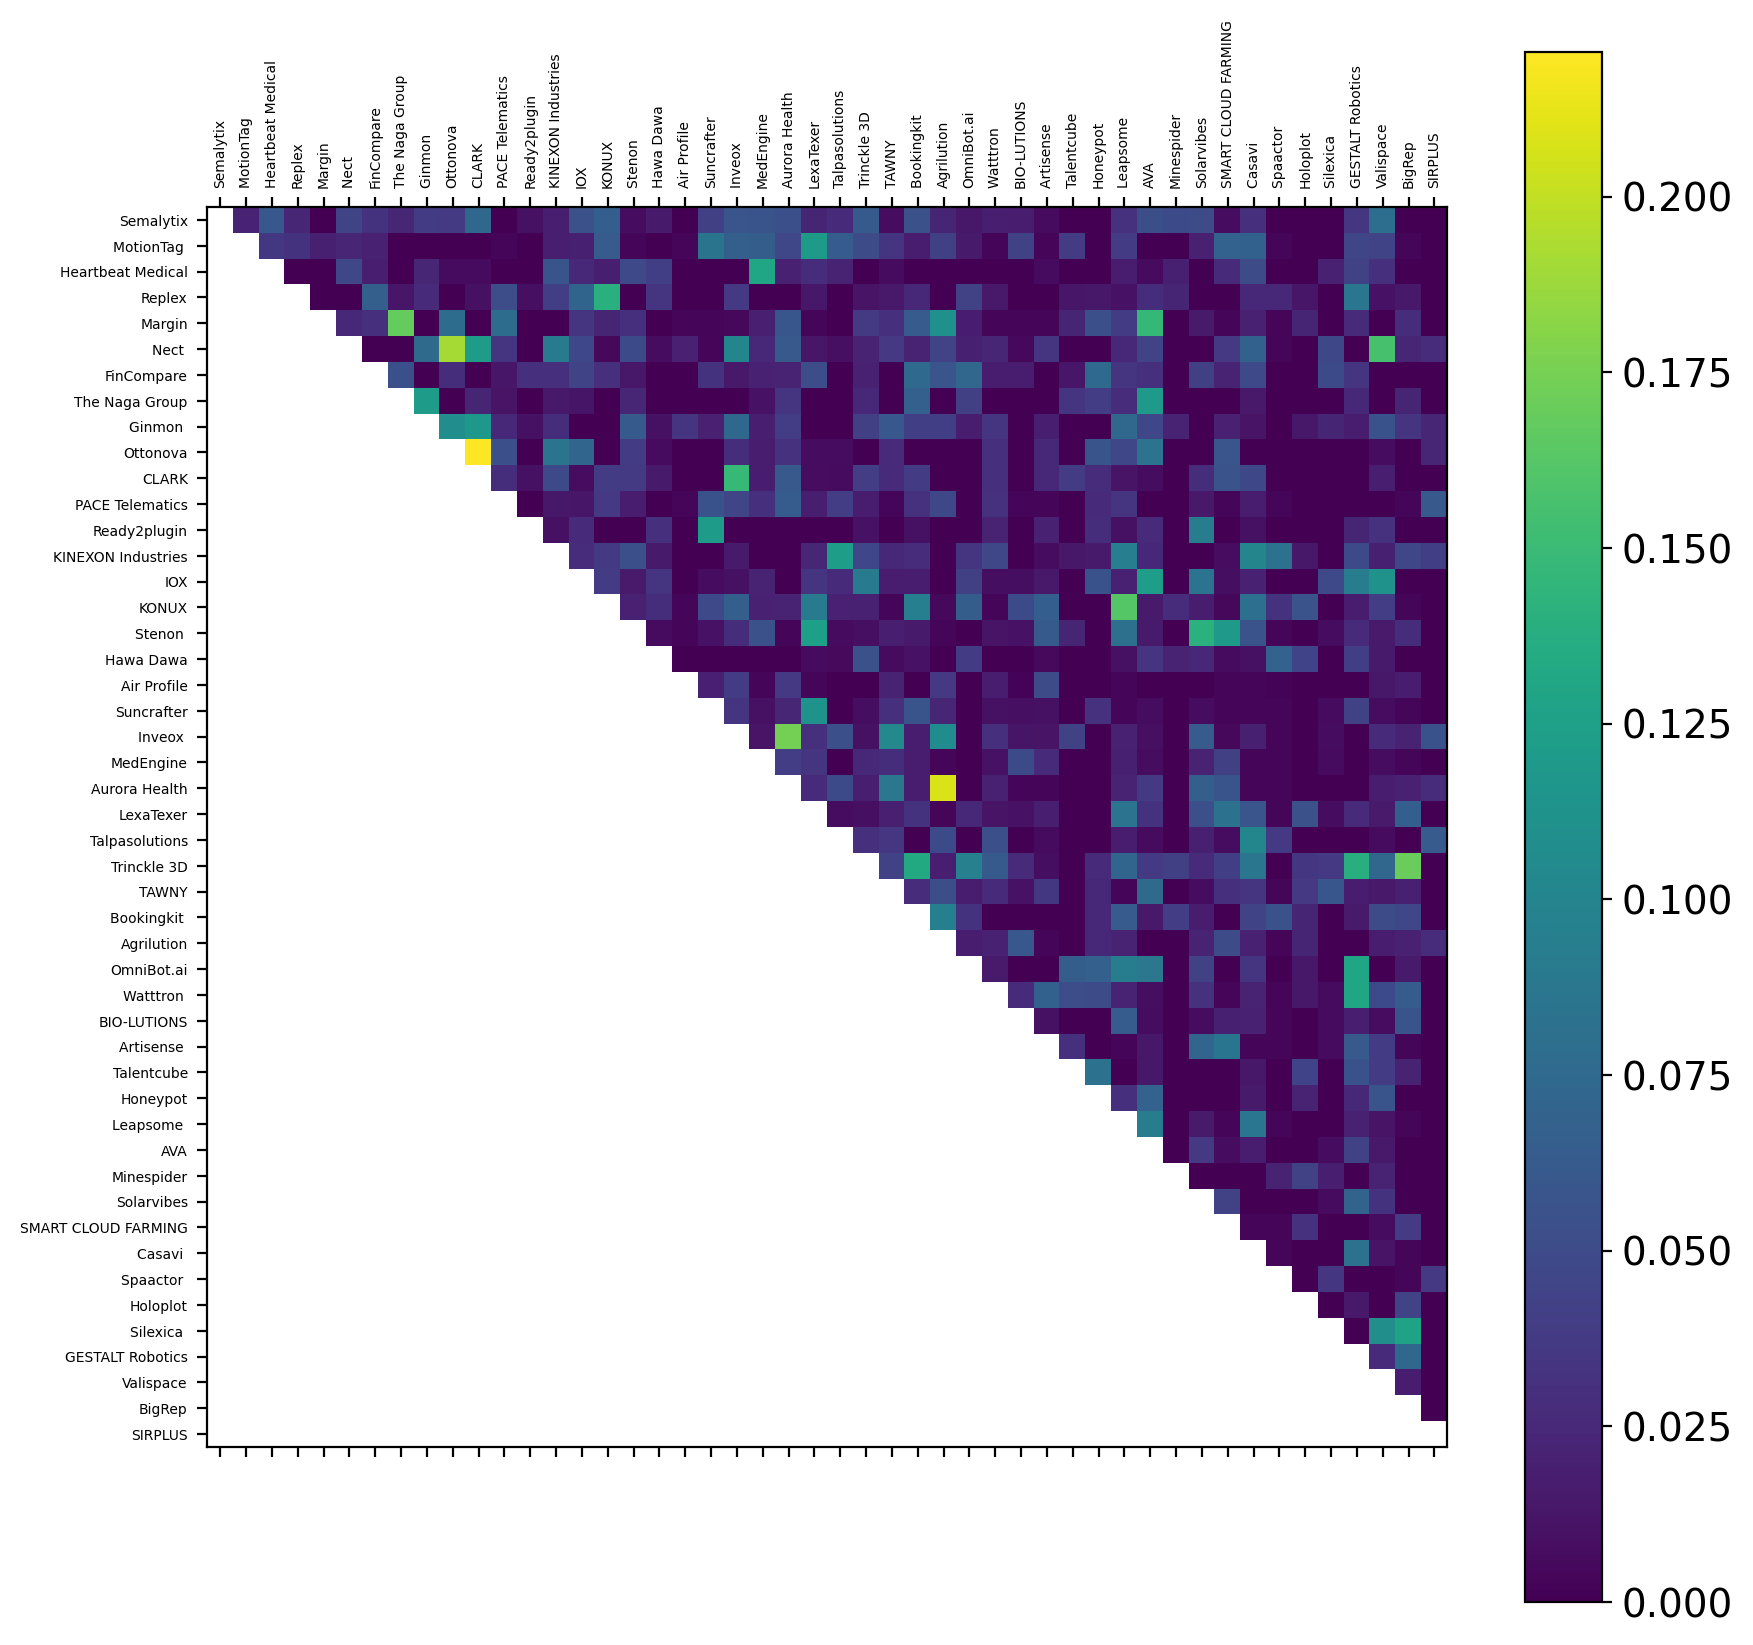

In [46]:
# https://stackoverflow.com/a/29432741/5599687

f = plt.figure(figsize=(10, 10), dpi=200)
xlabels = [f['name'] for f in forb_startups]
categories = list(set([f['category'].lower() for f in forb_startups]))
ylabels = xlabels
plt.matshow((similarity_matrix), fignum=f.number)
fontsz = 5
plt.xticks(range(len(xlabels)), xlabels, fontsize=fontsz, rotation=90)
plt.yticks(range(len(ylabels)), ylabels, fontsize=fontsz)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16);
plt.show()


# DEBUG

In [13]:
forb_classification['software as a service']

[{'name': 'Semalytix', 'url': 'https://semalytix.com/'},
 {'name': 'MotionTag ', 'url': 'https://motion-tag.com/en/'},
 {'name': 'Heartbeat Medical', 'url': 'https://heartbeat-med.de/'},
 {'name': 'Replex', 'url': 'http://replex.io/'}]

In [48]:
for f in forb_startups[:20]:
    print(f['name'],':',f['description'])
    print()

Semalytix : pharo patient market research process data agre want contact solut request polici privaci email know manag form submit answer earmark

MotionTag  : mobil motiontag transport ticket sketch creat encodingutf8 version10 xml privaci custom servic learn use mode provid document career analyt germani

Heartbeat Medical : patient prom outcom read qualiti life healthcar heartbeat provid measur report learn data treatment symptom oncolog care area digit hospit

Replex : cloud kubernet nativ cost manag environ govern 2020 technolog financ control solut replex regain virtual central modern enterpris career compani

Margin : trade margin support bot help featur exchang use strategi bitcoin termin us get custom secur make onli interfac experi easi

Nect  : nect cooki use data ident us inform requir custom insur set protect v save ago ceo r digit user contact

FinCompare : financ fincompar financi free bank corona compani offer best provid process get advic solut corpor fund purchas euro

In [42]:
print(info_score.similarity_score(catalogue['Semalytix']['description'],
                            catalogue['Heartbeat Medical']['description'],
                            descr_collection))
print(info_score.similarity_score(catalogue['Semalytix']['description'],
                            catalogue['FinCompare']['description'],
                            descr_collection))
print(info_score.similarity_score(catalogue['Semalytix']['description'],
                            catalogue['The Naga Group']['description'],
                            descr_collection))

0.060717390614544814
0.03239027940415933
0.02338440860989701
